## 使用ML方法组合估计器
2022-03-21
- 更改目标为平均价差；加入平均收盘价这个特征
2022-04-16
- 完善框架

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester

from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from sklearn.linear_model import LinearRegression
from tqdm import tqdm

import sys
sys.path.append(r'C:\Users\Administrator\Desktop\Repositories\Low-Frequency-Spread-Estimator\notebook\tools')
from train_tools import *
from get_signal import *
from naive_model import *

In [2]:
se = SpreadEstimator()
univ = ~np.isnan(se.data.data_dic['close'])  # 合法的univ

### 获得基本的训练数据

In [14]:
signal_spread = get_signal_spread(se)
target_spread = get_target('spread')
signal_rela = get_signal_rela(se)
target_rela = get_target('relative_spread')
target_wrela = get_target('vol_wtd_rel_bas')

mean corr: -0.4630, positive_corr_ratio: 0.0000, corr_IR: -16.7947
mean corr: 0.7924, positive_corr_ratio: 1.0000, corr_IR: 18.7505
mean corr: -0.3688, positive_corr_ratio: 0.0000, corr_IR: -8.7364
mean corr: -0.3920, positive_corr_ratio: 0.0000, corr_IR: -9.9100


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_50884/3483907079.py:8: RuntimeWarning: Mean of empty slice
  rel_sp[i] = np.nanmean(se.data.spread_dic[name][i-back+1:i+1],axis=0)


mean corr: -0.2082, positive_corr_ratio: 0.0000, corr_IR: -3.6871
mean corr: 0.0994, positive_corr_ratio: 0.9279, corr_IR: 1.2409
mean corr: -0.2317, positive_corr_ratio: 0.0000, corr_IR: -3.9265
mean corr: -0.3920, positive_corr_ratio: 0.0000, corr_IR: -9.9100


In [23]:
x_train_cs_spread, y_train_cs_spread = get_train_data_cs(signal_spread, target_spread)
x_train_cs_rela, y_train_cs_rela = get_train_data_cs(signal_spread, target_rela)
x_train_cs_wrela, y_train_cs_wrela = get_train_data_cs(signal_spread, target_wrela)

x_train_ts_spread, y_train_ts_spread = get_train_data_ts(signal_spread, target_spread)
x_train_ts_rela, y_train_ts_rela = get_train_data_ts(signal_spread, target_rela)
x_train_ts_wrela, y_train_ts_wrela = get_train_data_ts(signal_spread, target_wrela)

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 2651.56it/s]


In [ ]:
### 使用截面相关系数作为损失函数，xun

In [79]:
# signal[np.isnan(signal)] = 0.00
# rel_sp = se.data.spread_dic['vol_wtd_rel_bas'].copy()
x, y = get_xy(signal, rel_sp, univ)

x = torch.Tensor(x).to(device)
y = torch.Tensor(y).to(device).unsqueeze(dim=-1)

In [92]:
# 时序训练集
x, y = get_xy(signal[:,:1500,:], rel_sp[:,:1500], univ[:,:1500])

### 测试以MSE为损失函数，使用full_batch进行测试

#### 测试NN

In [4]:
sys.path.append('C:/Users/Administrator/Desktop/Daily-Frequency-Quant/QBG')
sys.path.append('C:/Users/HBG/Desktop/Repositories/Daily-Frequency-Quant/QBG')

from Model.MyDeepModel import *
from Model.Loss import *
from Model.tools.fitting_tools import *
from Model.tools.test_tools import *

#### Linear

In [87]:
import random
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

n = 4

model = nn.Linear(n, 1).to(device)
# model = GateNet(input_dim=2, output_dim=1, dropout=0.2, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2, weight_decay=0)
loss_func = MSELoss()

best_IC = 0

top =univ
t = time()
for i in range(20000):
    model.train()
    optimizer.zero_grad()
    loss = loss_func(model(x[:250000,:n]), y[:250000,:n])
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 2000 == 0:
        model.eval()
        print('epoch {}'.format(i + 1))
        print('loss: {:.4f}, time used: {:.4f}s'.format(np.sqrt(float(loss))*1e4, time()-t))
        print('test loss: {:.4f}, time used: {:.4f}s'.format(np.sqrt(float(loss_func(model(x[250000:,:n]), y[250000:,:n])))*1e4, time()-t))
        corr = test(model, signal[:,:,:n], rel_sp, univ, 180, 240)
        print('vs cs IC: {:.4f}'.format(np.mean(corr)))
#         corr = test_ts(model, signal[180:240,:,:n], rel_sp[180:240], univ[180:240], 0, 2080)
#         print('vs ts IC: {:.4f}'.format(np.mean(corr)))
        print()

epoch 2000
loss: 22.0370, time used: 1.2263s
test loss: 23.6224, time used: 1.2273s
vs cs IC: -0.0165

epoch 4000
loss: 11.4947, time used: 2.3024s
test loss: 10.9906, time used: 2.3024s
vs cs IC: 0.1798

epoch 6000
loss: 10.0744, time used: 3.3755s
test loss: 9.6947, time used: 3.3765s
vs cs IC: 0.3693

epoch 8000
loss: 10.0134, time used: 4.4496s
test loss: 9.6597, time used: 4.4506s
vs cs IC: 0.3792

epoch 10000
loss: 226.3380, time used: 5.5259s
test loss: 809.3943, time used: 5.5259s
vs cs IC: 0.3669

epoch 12000
loss: 10.0069, time used: 6.6037s
test loss: 9.6507, time used: 6.6037s
vs cs IC: 0.3827

epoch 14000
loss: 10.0067, time used: 7.6704s
test loss: 9.6535, time used: 7.6704s
vs cs IC: 0.3829

epoch 16000
loss: 10.0066, time used: 8.7428s
test loss: 9.6535, time used: 8.7438s
vs cs IC: 0.3830

epoch 18000
loss: 10.0069, time used: 9.8179s
test loss: 9.6510, time used: 9.8189s
vs cs IC: 0.3832

epoch 20000
loss: 10.0066, time used: 10.8866s
test loss: 9.6536, time used: 10.

#### GateNet

In [82]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

n = 4
model = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-2, weight_decay=0)
loss_func = MSELoss()

t = time()
for i in range(1000):
    model.train()
    optimizer.zero_grad()
    loss = loss_func(model(x[:250000,:n]), y[:250000,:n])
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 100 == 0:
        model.eval()
        print('epoch {}'.format(i + 1))
        print('loss: {:.4f}, time used: {:.4f}s'.format(np.sqrt(float(loss))*1e4, time()-t))
        print('test loss: {:.4f}, time used: {:.4f}s'.format(np.sqrt(float(loss_func(model(x[250000:,:n]), y[250000:,:n])))*1e4, time()-t))
        # corr = test(model, signal[:,:,:n], se.data.spread_dic['relative_spread'], univ, 20, 240)
        corr = test(model, signal[:,:,:n], rel_sp, univ, 180, 240)
        print('vs cs IC: {:.4f}'.format(np.mean(corr)))
#         corr = test_ts(model, signal[180:240,:,:n], rel_sp[180:240], univ[180:240], 0, 2080)
#         print('vs ts IC: {:.4f}'.format(np.mean(corr)))

epoch 100
loss: 6.9853, time used: 6.6686s
test loss: 7.1347, time used: 6.6716s
vs cs IC: 0.9241
epoch 200
loss: 4.5438, time used: 12.9608s
test loss: 4.6800, time used: 12.9628s
vs cs IC: 0.9198
epoch 300
loss: 4.0689, time used: 19.2636s
test loss: 4.1898, time used: 19.2666s
vs cs IC: 0.9188
epoch 400
loss: 3.8890, time used: 25.5618s
test loss: 3.9628, time used: 25.5638s
vs cs IC: 0.9253
epoch 500
loss: 3.8704, time used: 31.8536s
test loss: 3.9429, time used: 31.8556s
vs cs IC: 0.9261
epoch 600
loss: 3.8580, time used: 38.1483s
test loss: 3.9320, time used: 38.1503s
vs cs IC: 0.9266
epoch 700
loss: 3.8440, time used: 44.4526s
test loss: 3.9182, time used: 44.4546s
vs cs IC: 0.9271
epoch 800
loss: 3.8280, time used: 50.7928s
test loss: 3.9052, time used: 50.7948s
vs cs IC: 0.9276
epoch 900
loss: 3.8103, time used: 57.0858s
test loss: 3.8898, time used: 57.0888s
vs cs IC: 0.9282
epoch 1000
loss: 3.7907, time used: 63.3881s
test loss: 3.8700, time used: 63.3911s
vs cs IC: 0.9289


### 时序corr测试

### Linear

In [70]:
def test_ts(model, x: np.array, y: np.array, top, s, e, device: str = 'cuda'):
    corr = []
    
    for i in range(s, e):
        x_tmp = x[top[:, i], i]
        x_pre = model(torch.Tensor(x_tmp).to(device)).detach().cpu().numpy()
        x_tmp[np.isnan(x_tmp)] = 0
        se = (~np.isnan(y[top[:, i], i])) & (~np.isnan(x_pre[:,0]))
        pre = x_pre[se, 0]
        corr.append(np.corrcoef(pre, y[top[:, i], i][se])[0, 1])
    return corr

In [96]:
import random
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

n = 4

model = nn.Linear(n, 1).to(device)
# model = GateNet(input_dim=2, output_dim=1, dropout=0.2, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0)
loss_func = MSELoss()

best_IC = 0

top =univ
t = time()
for i in range(20000):
    model.train()
    optimizer.zero_grad()
    loss = loss_func(model(x[:,:n]), y[:,:n])
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 2000 == 0:
        model.eval()
        print('epoch {}'.format(i + 1))
        print('loss: {:.4f}, time used: {:.4f}s'.format(np.sqrt(float(loss))*1e4, time()-t))
        print('test loss: {:.4f}, time used: {:.4f}s'.format(np.sqrt(float(loss_func(model(x[250000:,:n]), y[250000:,:n])))*1e4, time()-t))
#         corr = test(model, signal[:,:,:n], rel_sp, univ, 180, 240)
#         print('vs cs IC: {:.4f}'.format(np.mean(corr)))
        corr = test_ts(model, signal[20:], rel_sp[20:], univ[20:], 1500, 2080)
        print('vs ts IC: {:.4f}'.format(np.mean(corr)))
        print()

epoch 2000
loss: 150.6842, time used: 1.2998s
test loss: 138.9352, time used: 1.3008s
vs ts IC: -0.2404

epoch 4000
loss: 88.0047, time used: 2.5904s
test loss: 90.6244, time used: 2.5914s
vs ts IC: 0.3058

epoch 6000
loss: 79.3046, time used: 3.8522s
test loss: 80.6356, time used: 3.8522s
vs ts IC: 0.6272

epoch 8000
loss: 79.2344, time used: 5.1164s
test loss: 80.2603, time used: 5.1169s
vs ts IC: 0.6438

epoch 10000
loss: 79.2344, time used: 6.3780s
test loss: 80.2599, time used: 6.3790s
vs ts IC: 0.6438

epoch 12000
loss: 79.3220, time used: 7.6595s
test loss: 80.8491, time used: 7.6595s
vs ts IC: 0.6442

epoch 14000
loss: 79.2345, time used: 8.9521s
test loss: 80.2628, time used: 8.9521s
vs ts IC: 0.6438

epoch 16000
loss: 79.2446, time used: 10.2206s
test loss: 80.1935, time used: 10.2206s
vs ts IC: 0.6438

epoch 18000
loss: 79.2344, time used: 11.5086s
test loss: 80.2607, time used: 11.5096s
vs ts IC: 0.6438

epoch 20000
loss: 79.2344, time used: 12.7814s
test loss: 80.2599, tim

In [97]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

n = 4
model = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=0)
loss_func = MSELoss()

top =univ
t = time()
for i in range(5000):
    model.train()
    optimizer.zero_grad()
    loss = loss_func(model(x[:,:n]), y[:,:n])
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        model.eval()
        print('epoch {}'.format(i + 1))
        print('loss: {:.4f}, time used: {:.4f}s'.format(np.sqrt(float(loss))*1e4, time()-t))
        print('test loss: {:.4f}, time used: {:.4f}s'.format(np.sqrt(float(loss_func(model(x[250000:,:n]), y[250000:,:n])))*1e4, time()-t))
#         corr = test(model, signal[:,:,:n], rel_sp, univ, 180, 240)
#         print('vs cs IC: {:.4f}'.format(np.mean(corr)))
        corr = test_ts(model, signal[20:], rel_sp[20:], univ[20:], 1500, 2080)
        print('vs ts IC: {:.4f}'.format(np.mean(corr)))
        print()

epoch 500
loss: 77.4587, time used: 50.2364s
test loss: 81.1218, time used: 50.2404s
vs ts IC: 0.6305

epoch 1000
loss: 76.5329, time used: 100.0501s
test loss: 80.1241, time used: 100.0531s
vs ts IC: 0.6358

epoch 1500
loss: 95.0223, time used: 150.1214s
test loss: 83.3967, time used: 150.1244s
vs ts IC: 0.5136

epoch 2000
loss: 78.1119, time used: 200.1480s
test loss: 81.0663, time used: 200.1520s
vs ts IC: 0.5059

epoch 2500
loss: 77.2178, time used: 249.9951s
test loss: 80.5498, time used: 249.9991s
vs ts IC: 0.5652

epoch 3000
loss: 76.9109, time used: 299.7829s
test loss: 79.4430, time used: 299.7869s
vs ts IC: 0.5694

epoch 3500
loss: 78.3530, time used: 350.8948s
test loss: 79.3821, time used: 350.8978s
vs ts IC: 0.5651

epoch 4000
loss: 75.0890, time used: 401.0940s
test loss: 78.7642, time used: 401.0970s
vs ts IC: 0.6075

epoch 4500
loss: 74.8389, time used: 451.1691s
test loss: 77.8886, time used: 451.1721s
vs ts IC: 0.6107

epoch 5000
loss: 74.4836, time used: 501.2371s
te

## 使用截面corr损失函数，重写训练函数

In [113]:
# 相对价差
from tqdm import tqdm

rel_sp = se.data.spread_dic['relative_spread'].copy()
back = 20
for i in range(rel_sp.shape[0]):
    if i < back - 1:
        rel_sp[i] = np.nan
    else:
        rel_sp[i] = np.nanmean(se.data.spread_dic['relative_spread'][i-back+1:i+1],axis=0)

device = 'cuda'
x = []
y = []

x_test = []
y_test = []
for i in tqdm(range(20,100)):
    sse = univ[i] & (~np.isnan(rel_sp[i]))
    for j in range(signal.shape[2]):
        sse = sse & (~np.isnan(signal[i,:,j]))
    if np.sum(sse) == 0:
        continue
    tmp = torch.Tensor(signal[i,sse]).to(device)
    tmp[torch.isnan(tmp)] = 0
    x.append(tmp)
    tmp = torch.Tensor(rel_sp[i:i+1,sse].T).to(device)
    tmp[torch.isnan(tmp)] = 0
    y.append(tmp)
for i in tqdm(range(180,240)):
    sse = univ[i] & (~np.isnan(rel_sp[i]))
    for j in range(signal.shape[2]):
        sse = sse & (~np.isnan(signal[i,:,j]))
    if np.sum(sse) == 0:
        continue
    tmp = torch.Tensor(signal[i,sse]).to(device)
    tmp[torch.isnan(tmp)] = 0
    x_test.append(tmp)
    tmp = torch.Tensor(rel_sp[i:i+1,sse].T).to(device)
    tmp[torch.isnan(tmp)] = 0
    y_test.append(tmp)


# 时序
# x = []
# y = []
# for i in tqdm(range(1500)):
#     sse = univ[:,i] & (~np.isnan(rel_sp[:,i]))
#     for j in range(signal.shape[2]):
#         sse = sse & (~np.isnan(signal[:,i,j]))
#     if np.sum(sse) == 0:
#         continue
#     tmp = torch.Tensor(signal[sse,i]).to(device)
#     tmp[torch.isnan(tmp)] = 0
#     x.append(tmp)
#     tmp = torch.Tensor(rel_sp[sse,i:i+1]).to(device)
#     tmp[torch.isnan(tmp)] = 0
#     y.append(tmp)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_43188/3692715653.py:10: RuntimeWarning: Mean of empty slice
  rel_sp[i] = np.nanmean(se.data.spread_dic['relative_spread'][i-back+1:i+1],axis=0)
100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 936.66it/s]


In [96]:
n = 4
# model = nn.Linear(n, 1).to(device)

model = GateNet(input_dim=n, output_dim=1, dropout=0.0, alpha=0.2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0)
loss_func = ICLoss()

train_cs(x, y, model, optimizer, loss_func, epochs=8, batch_size=1)

epoch: 0
-0.9273981266334409
vs cs IC: 0.9417
os cs IC: 0.9297
epoch: 1
-0.9335144895022033
vs cs IC: 0.9449
os cs IC: 0.9350
epoch: 2
-0.9375009390174366
vs cs IC: 0.9439
os cs IC: 0.9290
epoch: 3
-0.9367822525931186
vs cs IC: 0.9440
os cs IC: 0.9297
epoch: 4
-0.9350689786379455
vs cs IC: 0.9427
os cs IC: 0.9272
epoch: 5
-0.9373161059911134
vs cs IC: 0.9466
os cs IC: 0.9310
epoch: 6
-0.9362530346776619
vs cs IC: 0.9487
os cs IC: 0.9343
epoch: 7
-0.9381058870768938
vs cs IC: 0.9474
os cs IC: 0.9318


## 分段线性模型

In [60]:
class MultiLinear(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(MultiLinear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.Dense = nn.ModuleList([nn.Linear(input_dim, output_dim) for i in range(4)])

    def forward(self, x):
        close = x[:,-1]
        y = self.Dense[0](x)
        y[(5<=close) & (close<10)] = self.Dense[1](x[(5<=close) & (close<10)])
        y[(10<=close) & (close<25)] = self.Dense[2](x[(10<=close) & (close<25)])
        y[close>25] = self.Dense[3](x[close>25])
        return y

In [67]:
model = MultiLinear(4, 1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=2e-2)
loss_func = MSELoss()

train_cs(x, y, model, optimizer, loss_func, epochs=20, batch_size=1)

epoch: 0
83.74533516633595
vs cs IC: -0.2720
epoch: 1
14.599226839998936
vs cs IC: -0.4631
epoch: 2
5.998505532318819
vs cs IC: 0.2101
epoch: 3
33.398301455991486
vs cs IC: 0.3122
epoch: 4
60.06256252315873
vs cs IC: 0.3124
epoch: 5
44.75774668970852
vs cs IC: 0.1670
epoch: 6
10.97241209246588
vs cs IC: -0.3092
epoch: 7
8.13928235845363
vs cs IC: -0.1728
epoch: 8
41.72480783394888
vs cs IC: -0.1619
epoch: 9
61.00470444158459
vs cs IC: -0.2610
epoch: 10
37.586230717652235
vs cs IC: -0.3667
epoch: 11
7.1171695171518525
vs cs IC: 0.0578
epoch: 12
14.972052946158335
vs cs IC: 0.3201
epoch: 13
51.845594933692446
vs cs IC: 0.3321
epoch: 14
61.28515873902233
vs cs IC: 0.2760
epoch: 15
27.501615801601545
vs cs IC: 0.1155
epoch: 16
6.518513960195771
vs cs IC: -0.4684
epoch: 17
24.833321774259527
vs cs IC: -0.2511
epoch: 18
59.71931679367174
vs cs IC: -0.1819
epoch: 19
59.326485194213
vs cs IC: -0.1568


## 绘制预测和实际的散点图

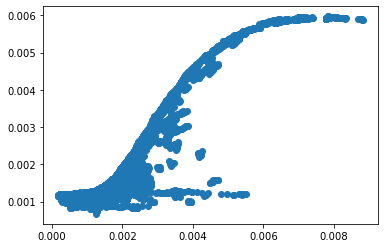

In [86]:
# GateNet cs

xx = []
yy = []

for i in range(10):
    xx += list(model(x_test[i]).detach().cpu().numpy()[:,0])
    yy += list(y_test[i].cpu().numpy()[:,0])
    
plt.scatter(yy, xx)
plt.show()
# print(np.mean((np.array(xx)-np.array(yy))**2))

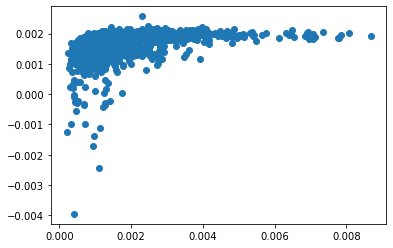

In [88]:
# linear cs

xx = []
yy = []
for i in range(1):
    xx += list(model(x_test[i]).detach().cpu().numpy()[:,0])
    yy += list(y_test[i].cpu().numpy()[:,0])
plt.scatter(yy, xx)
plt.show()

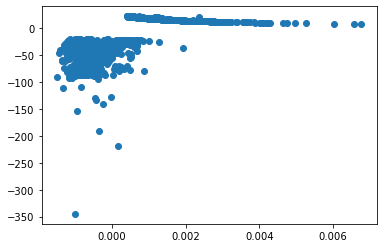

0.7001803088326078


In [66]:
# multilinear cs

xx = []
yy = []
for i in range(1):
    xx += list(model(x_test[i]).detach().cpu().numpy()[:,0])
    yy += list(y_test[i].cpu().numpy()[:,0])
plt.scatter(yy, xx)
plt.show()
print(np.corrcoef(xx,yy)[0,1])

#### 查看线性函数的参数

In [90]:
model.weight

Parameter containing:
tensor([[-3.0066e-02, -8.4163e-02,  6.1020e-03, -1.4581e-05]], device='cuda:0',
       requires_grad=True)

## 置换特征重要性
我们将使用置换特征重要性(Permutation Feature Importance)来研究不同特征对于模型预测价差的重要性. 我们将使用os数据进行测试,考虑到is和os的表现具有较高的一致性,这个选择不会造成麻烦.

In [118]:
# 首先计算原始模型的表现
corr = []
for i in range(len(x_test)):
    corr.append(np.corrcoef(model(x_test[i]).detach().cpu().numpy()[:,0], y_test[i].cpu().numpy()[:,0])[0,1])
print('model: {:.4f}'.format(np.mean(corr)))
nor = np.mean(corr)

# 对每个特征对换,计算表现以及下降的比例
for j in range(4):
    for i in range(len(x_test)):
        x_tmp = x_test[i]
        x_tmp[:,j] = torch.flip(x_tmp[:,j],dims=[0])
        corr.append(np.corrcoef(model(x_tmp).detach().cpu().numpy()[:,0], y_test[i].cpu().numpy()[:,0])[0,1])
        x_tmp[:,j] = torch.flip(x_tmp[:,j],dims=[0])
    print('{}: {:.4f}'.format(j, np.mean(corr)), (1-np.mean(corr)/nor)*100)


model: 0.9318
0: 0.9291 0.28758358157313646
1: 0.9301 0.18601228595827024
2: 0.9294 0.2573704977122171
3: 0.7273 21.951058199542484
